### **INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [3]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW: 
# !pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [4]:
#@ DOWNLOADING LIBRARIES AND DEPENDENCIES: 
from fastbook import *                                           # Getting all the Libraries. 
from fastai.callback.fp16 import *
from fastai.collab import *                                      # Getting all the Libraries.
from fastai.tabular.all import *                                 # Getting all the Libraries.

from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_numeric_dtype, is_string_dtype
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

### **GETTING THE DATASET:**
- I will use the dataset from [**Blue Book for Bulldozers Kaggle Competition**](https://www.kaggle.com/c/bluebook-for-bulldozers/overview) here. 

In [5]:
#@ GETTING DEPENDENCIES: UNCOMMENT BELOW: 
# creds = '{"username":"","key":""}'
# cred_path = Path('~/.kaggle/kaggle.json').expanduser()
# if not cred_path.exists():
#     cred_path.parent.mkdir(exist_ok=True)
#     cred_path.write_text(creds)
#     cred_path.chmod(0o600)

In [6]:
#@ GETTING THE DATASET: 
path = URLs.path("bluebook")                                # Path to the Dataset. 
path                                                        # Inspecting the Path. 

Path('/root/.fastai/archive/bluebook')

In [8]:
#@ DOWNLOADING THE DATASET: 
from kaggle import api
if not path.exists():
    path.mkdir(parents=True)                                       
    api.competition_download_cli('bluebook-for-bulldozers', path=path)  # Getting the Dataset. 
    file_extract(path/'bluebook-for-bulldozers.zip')
path.ls(file_type="text")                                               # Inspecting the Dataset. 

(#7) [Path('/root/.fastai/archive/bluebook/random_forest_benchmark_test.csv'),Path('/root/.fastai/archive/bluebook/median_benchmark.csv'),Path('/root/.fastai/archive/bluebook/TrainAndValid.csv'),Path('/root/.fastai/archive/bluebook/Test.csv'),Path('/root/.fastai/archive/bluebook/ValidSolution.csv'),Path('/root/.fastai/archive/bluebook/Valid.csv'),Path('/root/.fastai/archive/bluebook/Machine_Appendix.csv')]

**INSPECTING THE DATASET:**

In [9]:
#@ INSPECTING THE DATASET: 
data = pd.read_csv(path/"TrainAndValid.csv", low_memory=False)          # Reading the Dataset. 
data.columns                                                            # Inspecting the Columns of Dataset. 

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [10]:
#@ INSPECTING ORDINAL COLUMNS: 
data["ProductSize"].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [11]:
#@ INITIALIZING SUITABLE ORDERING: 
sizes = "Large", "Large / Medium", "Medium", "Small", "Mini", "Compact"    # Initializing Ordering. 
data["ProductSize"] = data["ProductSize"].astype("category")               # Initializing Category Type. 
data["ProductSize"].cat.set_categories(sizes, ordered=True, inplace=True)  # Initializing Suitable Ordering. 

**Note:**
- Since I will use the metric to calculate the **Root Mean Squared Log Error** between actual and predicted auction prices: I will take the log of dependent variable. 

In [12]:
#@ INITIALIZING THE LOG OF THE PRICES: 
dep_var = "SalePrice"                                                      # Dependent Variable. 
data[dep_var] = np.log(data[dep_var])                                      # Taking Log. 

**HANDLING DATES:**

In [13]:
#@ INITIALIZATION OF HANDLING DATES FUNCTION: 
data = add_datepart(data, "saledate")                                      # Handling Dates. 
data_test = pd.read_csv(path/"Test.csv", low_memory=False)                 # Reading Test Data. 
data_test = add_datepart(data_test, "saledate")                            # Handling Dates. 
#@ INSPECTING COLUMNS: 
" ".join(o for o in data.columns if o.startswith("sale"))                  # Inspecting Columns. 

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

**IMPLEMENTATION OF TABULAR PANDAS AND TABULAR PROC:**

In [14]:
#@ IMPLEMENTATION OF TABULAR PANDAS AND TABULAR PROC: 
procs = [Categorify, FillMissing]                                           # Initializing Processing. 
cond = (data.saleYear < 2011) | (data.saleMonth < 10)                       # Initializing Conditions. 
train_idx = np.where(cond)[0]                                               # Getting Index of Training. 
valid_idx = np.where(~cond)[0]                                              # Getting Index of Validation. 
splits = (list(train_idx), list(valid_idx))                                 # Initializing Splits. 

In [15]:
#@ IMPLEMENTATION OF TABULAR PANDAS AND TABULAR PROC: 
cont, cat = cont_cat_split(data, max_card=1, dep_var=dep_var)               # Getting Continuous and Categorical Data. 
tabular_pandas = TabularPandas(data, procs, cat, cont, y_names=dep_var, 
                               splits=splits)                               # Initializing Tabular Pandas. 
len(tabular_pandas.train), len(tabular_pandas.valid)                        # Inspecting the Tabular Pandas Object. 

(404710, 7988)

**Note:**
- max_card dictates what the maximum cardinality is number of categories or different values per variable. So anything with more than one unique value in this case will be a continuous variable.

In [16]:
#@ INSPECTING TABUALAR PANDAS OBJECT: 
tabular_pandas.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [17]:
#@ INSPECTING TABUALAR PANDAS OBJECT: 
tabular_pandas.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,963,298,43,0,0,0,59,1,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2006,11,46,16,3,320,1,1,1,1,1,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1745,529,57,98,0,3,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2004,3,13,26,4,86,1,1,1,1,1,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,336,111,0,0,0,0,39,32,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,2004,2,9,26,3,57,1,1,1,1,1,1,1.077754e+09,1,1


In [18]:
#@ SAVING THE TABULAR PANDAS OBJECT:
save_pickle(path/'tabular_pandas.pkl', tabular_pandas)         # Saving Tabular Pandas.
tabular_pandas = load_pickle(path/"tabular_pandas.pkl")        # Initializing Tabular Pandas.

### **DECISION TREE:**

In [19]:
#@ DEFINING DEPENDENT AND INDEPENDENT VARIABLES: 
xs, y = tabular_pandas.train.xs, tabular_pandas.train.y               # Initializing Training Data. 
valid_xs, valid_y = tabular_pandas.valid.xs, tabular_pandas.valid.y   # Initializing Validation Data. 

In [20]:
#@ CREATING DECISION TREE: 
m = DecisionTreeRegressor(max_leaf_nodes=4)                           # Initializing Decision Tree. 
m.fit(xs, y);                                                         # Initializing Training. 

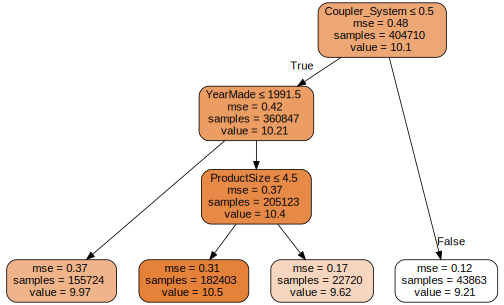

In [21]:
#@ INSPECTING LEAF NODES:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)           # Inspecting Decision Tree. 

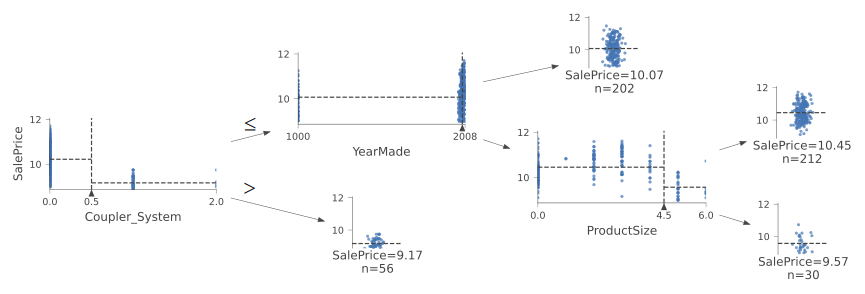

In [22]:
#@ INSPECTING THE LEAF NODES USING DTREEVIZ: 
samp_idx = np.random.permutation(len(y))[:500]                         # Initialization. 
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var, 
         fontname="DejaVu Sans", scale=1.6, label_fontsize=10, 
         orientation="LR")                                             # Inspecting Decision Tree. 

**Note:**
- It presents the distribution of the data for each split point. There are bulldozers made in the year 1000 but its just a missing value code which makes difficult in visualizing the values. 

In [23]:
#@ REPLACING OUTLIER FROM DATA: 
xs.loc[xs["YearMade"] < 1900, "YearMade"] = 1950                       # Replacing Outlier in Training Data. 
valid_xs.loc[valid_xs["YearMade"] < 1900, "YearMade"] = 1950           # Replacing Outlier in Validation Data. 

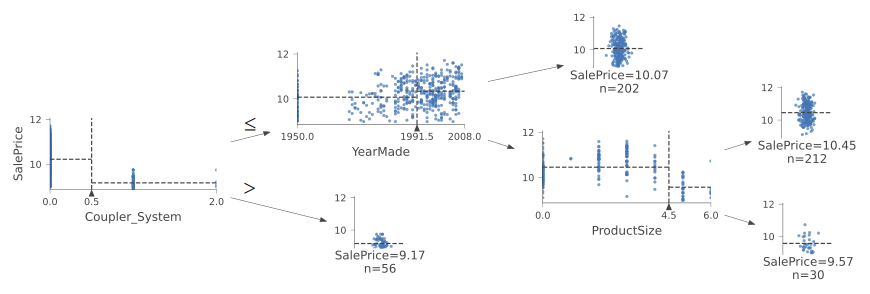

In [24]:
#@ IMPLEMENTATION OF DECISION TREE: 
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)                 # Initializing Decision Tree. 
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var, 
         fontname="DejaVu Sans", scale=1.6, label_fontsize=10, 
         orientation="LR")                                             # Inspecting Decision Tree. 

In [25]:
#@ CREATING DECISION TREE: WITHOUT STOPPING CRITERION: 
m = DecisionTreeRegressor()                                            # Initializing Decision Tree. 
m.fit(xs, y);                                                          # Training the DT. 

In [27]:
#@ FUNCTION FOR ROOT MEAN SQUARED ERROR OF MODEL: 
def r_mse(pred, y):                                                    # Defining RMSE Function. 
    return round(math.sqrt(((pred - y)**2).mean()), 6)                 # Getting RMSE. 
def m_rmse(m, xs, y):                                                  # Initializing Function. 
    return r_mse(m.predict(xs), y)                                     # Getting RMSE. 

#@ IMPLEMENTATION: 
m_rmse(m, xs, y)                                                       # Inspecting RMSE. 
m_rmse(m, valid_xs, valid_y)                                           # Inspecting RMSE. 

0.332913

In [28]:
#@ INSPECTING NUMBER OF LEAVES: 
m.get_n_leaves(), len(xs)

(324528, 404710)

In [29]:
#@ CREATING OPTIMAL DECISION TREE: 
m = DecisionTreeRegressor(min_samples_leaf=25)              # Initializing DT: More than 25 Data. 
m.fit(tabular_pandas.train.xs, tabular_pandas.train.y)      # Initializing Training. 
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)              # Inspecting RMSE. 

(0.248593, 0.323339)

In [30]:
#@ INSPECTING NUMBER OF LEAVES: 
m.get_n_leaves(), len(xs)

(12397, 404710)